<a href="https://colab.research.google.com/github/Bicchie/Skin-Lesions-Classification/blob/main/7_Vision_Transformer_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialization

In [ ]:
!pip install tensorflow_addons
!pip install --quiet vit-keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image
import pandas as pd
from keras import layers
from vit_keras import vit
from keras import models
import tensorflow_addons as tfa
import os
import math
import shutil
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
TRAIN_DIR = '/content/gdrive/MyDrive/SkinCancer/OriginalDataset/train'
VAL_DIR = '/content/gdrive/MyDrive/SkinCancer/OriginalDataset/val'
TEST_DIR = '/content/gdrive/MyDrive/SkinCancer/OriginalDataset/test'
MODELS_PATH = '/content/gdrive/MyDrive/SkinCancer/Models'

LOCAL_MODELS_FOLDER = "/content/models"
if not os.path.exists(LOCAL_MODELS_FOLDER):
  os.makedirs(LOCAL_MODELS_FOLDER)
GLOBAL_MODELS_FOLDER = "/content/gdrive/MyDrive/SkinCancer/Models/VisionTransformer"
if not os.path.exists(GLOBAL_MODELS_FOLDER):
  os.makedirs(GLOBAL_MODELS_FOLDER)

CLASSES = ['Actinic', 'BCC', 'Dermatofibroma', 'Keratosis', 'Melanoma', 'Nevu', 'Vascular']
BATCH_SIZE = 32
RANDOM_SEED = 42
EPOCHS=50
DROPOUT = 0.1
DROPOUT_MLP = 0.5

In [ ]:
def run_experiment(model, epochs, patience, model_name):
    monitor="val_loss"
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )

    save_path = LOCAL_MODELS_FOLDER + '/' + model_name + ".h5"
    checkpoint_callback = [keras.callbacks.EarlyStopping(monitor=monitor, patience=patience), #we implement EarlyStopping to prevent overfitting
                           keras.callbacks.ModelCheckpoint(
                              save_path,
                              monitor=monitor,
                              save_best_only=True,
                              save_weights_only=True,
                          )]

    history = model.fit(training_images,
                    epochs=epochs,
                    validation_data=val_images,
                    callbacks=checkpoint_callback,
                    class_weight=class_weight)

    model.load_weights(save_path)
    
    shutil.copy(save_path, GLOBAL_MODELS_FOLDER + '/' + model_name + '.h5')

    return history


def evaluate_model(model, test_ds):
  test_loss, test_accuracy = model.evaluate(test_ds)
  print("Loss on test set: " +str(test_loss))
  print("Accuracy on test set: " +str(test_accuracy))
  test_labels = np.concatenate([label for image, label in test_ds], axis=0) # retrieve the labels of the test set
  test_predictions = model.predict(test_ds)  # probabilities for all classes
  test_predictions = np.argmax(test_predictions, axis=-1)  # index of the classes with largest probability
  print(metrics.classification_report(test_labels, test_predictions, target_names=CLASSES, digits=4))

def plot_confusionmatrix(model, test_ds):
  test_labels = np.concatenate([label for image, label in test_ds], axis=0) # retrieve the labels of the test set
  test_predictions = model.predict(test_ds, verbose=1)  # probabilities for all classes
  test_predictions = np.argmax(test_predictions, axis=-1)  # index of the classes with largest probability
  # plot confusion matrix
  fig, ax = plt.subplots(figsize=(10, 10))
  ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions, xticks_rotation='vertical', ax=ax, display_labels=CLASSES)


def create_class_weight(labels_dict,mu=0.7):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 0.5 else 0.5
    
    return class_weight

# actually compute the CLASS WEIGHTS
labels_dict = {0:327, 1:514, 2:115, 3:1099, 4:1113, 5:6705, 6:142}

class_weight = create_class_weight(labels_dict)

###Dataset Loading

Note that since 450x600 is too large, It is used the interpolation tool in Keras to resize the images in 224x224, also to fit the input of most pretrained networks.

In [ ]:
training_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=True,
    seed=RANDOM_SEED
)

val_images = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=True,
    seed=RANDOM_SEED
)

test_images = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=False,
    seed=RANDOM_SEED
)

Found 7014 files belonging to 7 classes.
Found 1500 files belonging to 7 classes.
Found 1511 files belonging to 7 classes.


# Image classification with Vision Transformer

Keras provide an example regarding the usage of ViT in Image Classification: https://keras.io/examples/vision/image_classification_with_vision_transformer/

Prova diverse taglie di PATCH: 8x8, 16x16, 32x32, 56x56, 112x112

Capisci perché classifica solo NEI se tieni patches piccole

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
patch_size = 32  # Size of the patches to be extract from the input images
num_patches = (IMAGE_HEIGHT // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [512, 256]  # Size of the dense layers of the final classifier

Implement patch creation as a layer.

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

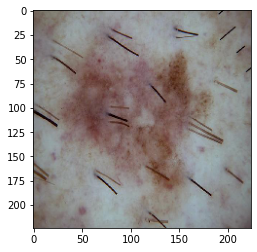

In [ ]:
#glioma
img_path_ex = "/content/gdrive/MyDrive/SkinCancer/skin-cancer-isic-dataset-2018/Fold_1/ISIC_0024323.jpg"
# We preprocess the image into a 4D tensor (adding batch dimension)
img = image.load_img(img_path_ex, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
img_tensor_ex = image.img_to_array(img)
img_tensor_ex = np.expand_dims(img_tensor_ex, axis=0) # add batch dimension
plt.imshow(img_tensor_ex[0].astype('uint8'))

Image size: 224 X 224
Patch size: 32 X 32
Patches per image: 49
Elements per patch: 3072


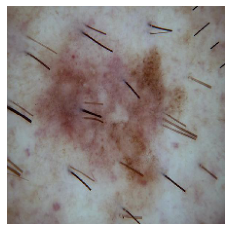

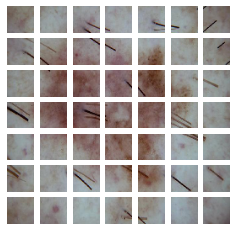

In [ ]:
plt.figure(figsize=(4, 4))
img = img_tensor_ex[0]
plt.imshow(img.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([img]), size=(IMAGE_WIDTH,IMAGE_HEIGHT)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {IMAGE_HEIGHT} X {IMAGE_WIDTH}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

### Built the Model

In [ ]:
def mlp(x, hidden_units):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(DROPOUT)(x)
    return x

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier(patch_size, num_patches,projection_dim):
    inputs = layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(DROPOUT_MLP)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units)
    # Classify outputs.
    logits = layers.Dense(len(CLASSES))(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits, name="VisionTransformer")
    return model

## Experiment with PATCH: 8x8

In [ ]:
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (IMAGE_HEIGHT // patch_size) ** 2
projection_dim = 64

model = create_vit_classifier(patch_size, num_patches,projection_dim)
model.summary()

In [ ]:
#model , history = run_model(model,'8x8', training_images, val_images, EPOCHS, 5, class_weight)
history = run_experiment(model, 50, 5, '8x8')

Epoch 1/50
220/220 [==============================] - 131s 551ms/step - loss: 2.7591 - accuracy: 0.5934 - val_loss: 1.5058 - val_accuracy: 0.6700
Epoch 2/50
220/220 [==============================] - 124s 559ms/step - loss: 1.9178 - accuracy: 0.6567 - val_loss: 1.4204 - val_accuracy: 0.6700
Epoch 3/50
220/220 [==============================] - 121s 548ms/step - loss: 1.9057 - accuracy: 0.6691 - val_loss: 1.4146 - val_accuracy: 0.6700
Epoch 4/50
220/220 [==============================] - 122s 552ms/step - loss: 1.9044 - accuracy: 0.6691 - val_loss: 1.4137 - val_accuracy: 0.6700
Epoch 5/50
220/220 [==============================] - 122s 553ms/step - loss: 1.9054 - accuracy: 0.6691 - val_loss: 1.4151 - val_accuracy: 0.6700
Epoch 6/50
220/220 [==============================] - 121s 548ms/step - loss: 1.9048 - accuracy: 0.6691 - val_loss: 1.4173 - val_accuracy: 0.6700
Epoch 7/50
220/220 [==============================] - 122s 551ms/step - loss: 1.9047 - accuracy: 0.6691 - val_loss: 1.4133 -

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 224s 5s/step - loss: 1.4101 - accuracy: 0.6664
Loss on test set: 1.4100688695907593
Accuracy on test set: 0.6664460897445679
                precision    recall  f1-score   support

       Actinic     0.0000    0.0000    0.0000        50
           BCC     0.0000    0.0000    0.0000        80
Dermatofibroma     0.0000    0.0000    0.0000        18
     Keratosis     0.0000    0.0000    0.0000       166
      Melanoma     0.0000    0.0000    0.0000       168
          Nevu     0.6664    1.0000    0.7998      1007
      Vascular     0.0000    0.0000    0.0000        22

      accuracy                         0.6664      1511
     macro avg     0.0952    0.1429    0.1143      1511
  weighted avg     0.4442    0.6664    0.5331      1511



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


48/48 [==============================] - 9s 191ms/step


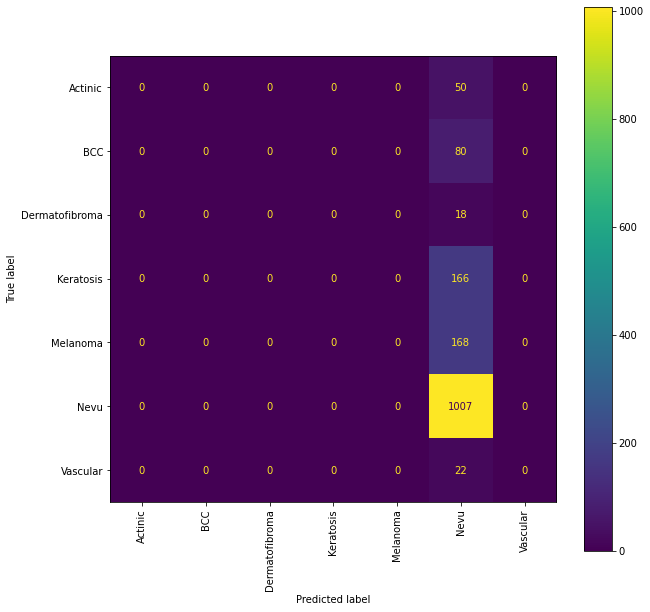

In [ ]:
plot_confusionmatrix(model, test_images)

## Experiment with PATCH: 16x16

In [ ]:
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (IMAGE_HEIGHT // patch_size) ** 2
projection_dim = 64

model = create_vit_classifier(patch_size, num_patches,projection_dim)
model.summary()

In [ ]:
history = run_experiment(model, EPOCHS, 3, '16x16')

Epoch 1/50
220/220 [==============================] - 39s 133ms/step - loss: 2.8073 - accuracy: 0.4534 - val_loss: 1.4541 - val_accuracy: 0.6700
Epoch 2/50
220/220 [==============================] - 28s 125ms/step - loss: 1.9238 - accuracy: 0.6528 - val_loss: 1.5848 - val_accuracy: 0.6700
Epoch 3/50
220/220 [==============================] - 28s 126ms/step - loss: 1.9006 - accuracy: 0.6679 - val_loss: 1.2459 - val_accuracy: 0.6700
Epoch 4/50
220/220 [==============================] - 28s 126ms/step - loss: 1.7984 - accuracy: 0.6449 - val_loss: 1.2524 - val_accuracy: 0.6293
Epoch 5/50
220/220 [==============================] - 28s 126ms/step - loss: 1.7710 - accuracy: 0.5803 - val_loss: 1.2519 - val_accuracy: 0.5987
Epoch 6/50
220/220 [==============================] - 28s 126ms/step - loss: 1.7604 - accuracy: 0.5195 - val_loss: 1.2720 - val_accuracy: 0.5507


In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 4s 91ms/step - loss: 1.2420 - accuracy: 0.6664
Loss on test set: 1.242045521736145
Accuracy on test set: 0.6664460897445679
                precision    recall  f1-score   support

       Actinic     0.0000    0.0000    0.0000        50
           BCC     0.0000    0.0000    0.0000        80
Dermatofibroma     0.0000    0.0000    0.0000        18
     Keratosis     0.0000    0.0000    0.0000       166
      Melanoma     0.0000    0.0000    0.0000       168
          Nevu     0.6664    1.0000    0.7998      1007
      Vascular     0.0000    0.0000    0.0000        22

      accuracy                         0.6664      1511
     macro avg     0.0952    0.1429    0.1143      1511
  weighted avg     0.4442    0.6664    0.5331      1511



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


48/48 [==============================] - 5s 93ms/step


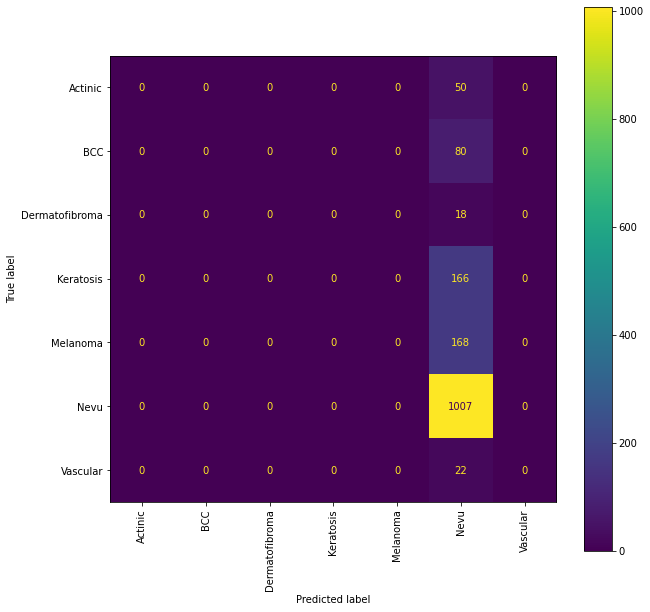

In [ ]:
plot_confusionmatrix(model, test_images)

## Experiment with PATCH: 32x32

In [ ]:
patch_size = 32  # Size of the patches to be extract from the input images
num_patches = (IMAGE_HEIGHT // patch_size) ** 2
projection_dim = 64

model = create_vit_classifier(patch_size, num_patches,projection_dim)
model.summary()

In [ ]:
history = run_experiment(model, EPOCHS, 3, '32x32')

Epoch 1/50
220/220 [==============================] - 36s 121ms/step - loss: 2.1462 - accuracy: 0.4705 - val_loss: 1.4845 - val_accuracy: 0.6700
Epoch 2/50
220/220 [==============================] - 26s 117ms/step - loss: 1.9352 - accuracy: 0.5932 - val_loss: 1.5048 - val_accuracy: 0.6700
Epoch 3/50
220/220 [==============================] - 26s 117ms/step - loss: 1.9159 - accuracy: 0.6496 - val_loss: 1.3819 - val_accuracy: 0.6700
Epoch 4/50
220/220 [==============================] - 26s 116ms/step - loss: 1.9102 - accuracy: 0.6503 - val_loss: 1.4914 - val_accuracy: 0.5880
Epoch 5/50
220/220 [==============================] - 26s 116ms/step - loss: 1.7991 - accuracy: 0.5707 - val_loss: 1.2057 - val_accuracy: 0.5893
Epoch 6/50
220/220 [==============================] - 26s 115ms/step - loss: 1.7430 - accuracy: 0.5610 - val_loss: 1.2915 - val_accuracy: 0.5587
Epoch 7/50
220/220 [==============================] - 26s 117ms/step - loss: 1.6924 - accuracy: 0.5714 - val_loss: 1.2462 - val_ac

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 4s 87ms/step - loss: 1.1971 - accuracy: 0.5910
Loss on test set: 1.197137713432312
Accuracy on test set: 0.5909993648529053
                precision    recall  f1-score   support

       Actinic     0.0000    0.0000    0.0000        50
           BCC     0.0000    0.0000    0.0000        80
Dermatofibroma     0.0000    0.0000    0.0000        18
     Keratosis     0.1912    0.5241    0.2802       166
      Melanoma     0.4375    0.0417    0.0761       168
          Nevu     0.7683    0.7934    0.7807      1007
      Vascular     0.0000    0.0000    0.0000        22

      accuracy                         0.5910      1511
     macro avg     0.1996    0.1942    0.1624      1511
  weighted avg     0.5817    0.5910    0.5595      1511



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


48/48 [==============================] - 4s 85ms/step


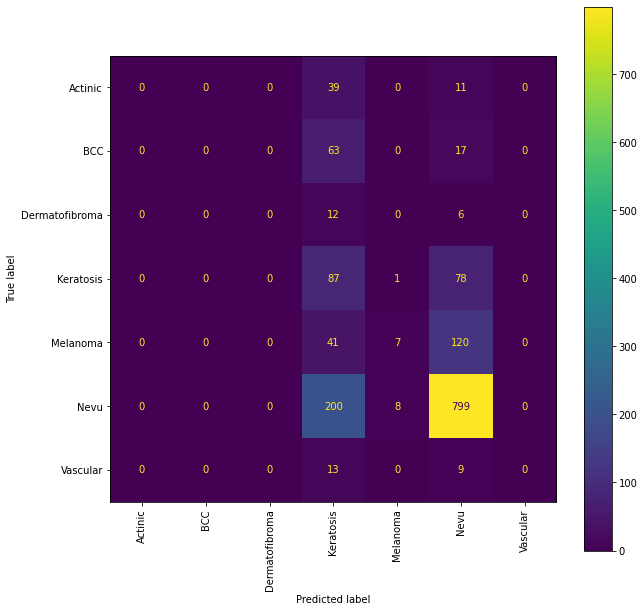

In [ ]:
plot_confusionmatrix(model, test_images)

## Experiment with PATCH: 56x56

In [ ]:
patch_size = 56  # Size of the patches to be extract from the input images
num_patches = (IMAGE_HEIGHT // patch_size) ** 2
projection_dim = 64

model = create_vit_classifier(patch_size, num_patches,projection_dim)
model.summary()

In [ ]:
history = run_experiment(model, EPOCHS, 3, '56x56')

Epoch 1/50
220/220 [==============================] - 36s 121ms/step - loss: 2.0482 - accuracy: 0.4792 - val_loss: 1.4047 - val_accuracy: 0.6700
Epoch 2/50
220/220 [==============================] - 26s 115ms/step - loss: 1.9347 - accuracy: 0.6363 - val_loss: 1.4305 - val_accuracy: 0.6700
Epoch 3/50
220/220 [==============================] - 26s 116ms/step - loss: 1.9157 - accuracy: 0.6567 - val_loss: 1.3261 - val_accuracy: 0.6700
Epoch 4/50
220/220 [==============================] - 26s 116ms/step - loss: 1.8425 - accuracy: 0.5925 - val_loss: 1.3204 - val_accuracy: 0.6033
Epoch 5/50
220/220 [==============================] - 26s 117ms/step - loss: 1.7770 - accuracy: 0.5767 - val_loss: 1.2904 - val_accuracy: 0.6180
Epoch 6/50
220/220 [==============================] - 26s 116ms/step - loss: 1.7300 - accuracy: 0.5751 - val_loss: 1.2347 - val_accuracy: 0.5553
Epoch 7/50
220/220 [==============================] - 26s 115ms/step - loss: 1.7033 - accuracy: 0.5667 - val_loss: 1.2546 - val_ac

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 4s 85ms/step - loss: 0.9141 - accuracy: 0.6592
Loss on test set: 0.9141429662704468
Accuracy on test set: 0.6591660976409912
                precision    recall  f1-score   support

       Actinic     0.2105    0.0800    0.1159        50
           BCC     0.4054    0.1875    0.2564        80
Dermatofibroma     0.2500    0.0556    0.0909        18
     Keratosis     0.3130    0.2470    0.2761       166
      Melanoma     0.3363    0.4524    0.3858       168
          Nevu     0.8073    0.8401    0.8234      1007
      Vascular     0.2826    0.5909    0.3824        22

      accuracy                         0.6592      1511
     macro avg     0.3722    0.3505    0.3330      1511
  weighted avg     0.6453    0.6592    0.6460      1511



48/48 [==============================] - 4s 83ms/step


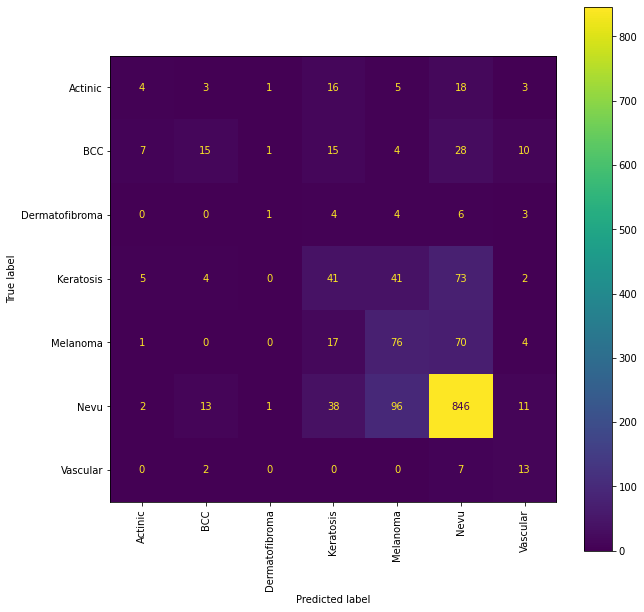

In [ ]:
plot_confusionmatrix(model, test_images)

## Experiment with PATCH: 112x112

In [ ]:
patch_size = 112  # Size of the patches to be extract from the input images
num_patches = (IMAGE_HEIGHT // patch_size) ** 2
projection_dim = 64

model = create_vit_classifier(patch_size, num_patches,projection_dim)
model.summary()

In [ ]:
history = run_experiment(model, EPOCHS, 3, '112x112')

Epoch 1/50
220/220 [==============================] - 35s 119ms/step - loss: 1.9969 - accuracy: 0.5173 - val_loss: 1.6205 - val_accuracy: 0.6700
Epoch 2/50
220/220 [==============================] - 26s 116ms/step - loss: 1.9254 - accuracy: 0.6104 - val_loss: 1.3580 - val_accuracy: 0.6700
Epoch 3/50
220/220 [==============================] - 26s 115ms/step - loss: 1.8821 - accuracy: 0.5994 - val_loss: 1.3870 - val_accuracy: 0.6287
Epoch 4/50
220/220 [==============================] - 26s 115ms/step - loss: 1.8329 - accuracy: 0.5911 - val_loss: 1.4682 - val_accuracy: 0.5333
Epoch 5/50
220/220 [==============================] - 26s 115ms/step - loss: 1.8219 - accuracy: 0.5924 - val_loss: 1.3178 - val_accuracy: 0.6020
Epoch 6/50
220/220 [==============================] - 26s 115ms/step - loss: 1.7989 - accuracy: 0.5838 - val_loss: 1.2890 - val_accuracy: 0.6133
Epoch 7/50
220/220 [==============================] - 25s 113ms/step - loss: 1.7816 - accuracy: 0.5804 - val_loss: 1.2924 - val_ac

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 4s 85ms/step - loss: 1.2725 - accuracy: 0.6175
Loss on test set: 1.2725166082382202
Accuracy on test set: 0.6174718737602234
                precision    recall  f1-score   support

       Actinic     0.0000    0.0000    0.0000        50
           BCC     0.0000    0.0000    0.0000        80
Dermatofibroma     0.0000    0.0000    0.0000        18
     Keratosis     0.2085    0.2952    0.2444       166
      Melanoma     0.2857    0.1310    0.1796       168
          Nevu     0.7189    0.8560    0.7815      1007
      Vascular     0.0000    0.0000    0.0000        22

      accuracy                         0.6175      1511
     macro avg     0.1733    0.1832    0.1722      1511
  weighted avg     0.5338    0.6175    0.5676      1511



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


48/48 [==============================] - 4s 86ms/step


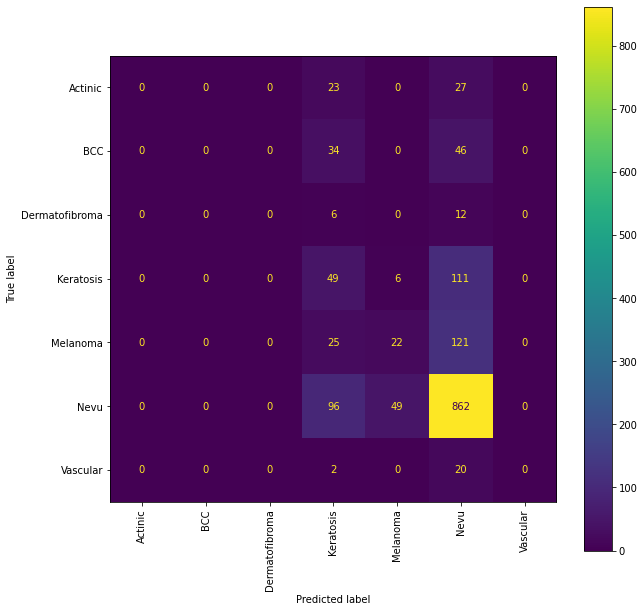

In [ ]:
plot_confusionmatrix(model, test_images)